In [1]:
import rasterio
import os
from glob import glob
import random
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
img_root_sat = "../data/interim/gee_sat/sen2a_c3_256x_pch"
img_paths_sat = glob(os.path.join(img_root_sat, "*"))


In [3]:
def find_minmax(img_paths):
    smallest_min = np.inf; highest_max = -1 * np.inf

    for i in tqdm(range(len(img_paths))):
        with rasterio.open(img_paths[i]) as ds:
            img = ds.read([1,2,3]) #(C,W,H)
            
        img = np.moveaxis(img, source = (0,1,2), destination = (2,0,1)) #(W,H,C)   
        vmax = img.max() ; vmin = img.min()
        if vmax > highest_max:
            highest_max = vmax
        if vmin < smallest_min:
            smallest_min = vmin

    return smallest_min, highest_max

# smallest_min, highest_max = find_minmax(img_paths_sat)
# print(f"min : {smallest_min}, max : {highest_max}")

def find_minmax_dl(dl):
    smallest_min = np.inf; highest_max = -1 * np.inf

    for X in tqdm(dl):
        vmax = X.max() ; vmin = X.min()
        if vmax > highest_max:
            highest_max = vmax
        if vmin < smallest_min:
            smallest_min = vmin

    return smallest_min, highest_max       
                

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from typing import List

In [5]:
class SentinelDataset(Dataset):
    """Desc : Dataset class for satelite data downloaded from google eath engine"""
    def __init__(self, paths:List[str], transform:Compose = None, sentinel_scaling_factor = None):
        """
        Inputs 
             - paths : List of image paths
             - transform : Any Pytorch transformations
        NOTE : GEE states to divide dataset by 10,000 however values are difficult to be visualized, 
        so we will normalize the values btw 0 and 1
        """
        self.paths = paths
        self.transform = transform
        self.sentinel_scaling_factor = sentinel_scaling_factor

    def __len__(self):
        """Desc : Return dataset size"""
        return len(self.paths)
    
    def __getitem__(self, idx:int):
        """
        Desc : Return a single item Based on Index
        Inputs 
            - idx : index
        """
        with rasterio.open(self.paths[idx]) as ds:
            img = ds.read([1,2,3]) #(C,W,H)
            img = torch.tensor(img, dtype = torch.float32)
            img = img / self.sentinel_scaling_factor
            #! Converted to torch Tensors here. Note we will be not using ToTensor
            #! function as it automatically normalizes values between 0-1, instead we 
            #! will find normalization means and stds

        if self.transform:
            img = self.transform(img)

        return img, self.paths[idx]

 
 # This below is just a copy from utils
class DATASET_MEAN_STD():
    """Gets the mean and standard deviation of a datastet"""
    def __init__(self, DATASET, batch_size:int = 512):
        super().__init__()
        self.DATASET = DATASET
        self.batch_size = batch_size

    def get_sshsph_my_stats(self,image_paths:List[str]):
        """
        Computes the mean and std for SSHSPH_MY dataset
        """
        c_sum, c_sq_sum, total_pixels = 0,0,0

        d = self.DATASET(image_paths)
        dl = DataLoader(d, batch_size = self.batch_size)
        for data,path in tqdm(dl): # note here we dont have traget else should be (data,labs)
            b,c,w,h = data.shape
            num_pixels = b * w * h
            assert c == 3, f"Num channels incorrect, got c = {c}"
            c_sum += torch.sum(data, dim = [0,2,3]) # Sum across channels, data.shape = (b,c,w,h)
            c_sq_sum += torch.sum(data**2 , dim = [0,2,3])

            total_pixels += num_pixels
        
        mean = c_sum / total_pixels
        std = ((c_sq_sum/total_pixels) - (mean**2))**0.5

        return mean,std


In [32]:
# mean_std_dataset = DATASET_MEAN_STD(SentinelDataset, batch_size=512)
# mean,std = mean_std_dataset.get_sshsph_my_stats(img_paths_sat)

100%|██████████| 224/224 [14:12<00:00,  3.80s/it]


In [33]:
# mean, std

(tensor([0.0738, 0.0956, 0.1218]), tensor([0.1069, 0.0973, 0.0943]))

In [6]:
mean = [0.0738, 0.0956, 0.1218] ; std = [0.1069, 0.0973, 0.0943]
sentinel_dataset = SentinelDataset(img_paths_sat, Compose([Normalize(mean = mean, std = std)]))
sentinel_loader = DataLoader(sentinel_dataset, batch_size=512)

# smallest_min, highest_max = find_minmax_dl(sentinel_loader)
# f"smallest_min : {smallest_min}, highest_max : {highest_max}"

In [53]:
def get_color_mean_dataset(dl:DataLoader):
    """
    Desc : Return a mean and std for dataset
    """
    c_mus = []; c3_mus = [], c_stds = [] ; c3_stds = []
    for X in dl:
        # get mean and std of batch
        c_mu = X.mean()
        c3_mu = X.mean(axis = (0,2,3)) # (3,)
        c3_std = X.std(axis = (0,2,3)) # (3,)
    return c_mu, c3_mu


sentinel_loader = DataLoader(sentinel_dataset, batch_size = 512)
for X, path in sentinel_loader:
    print(X.min(), X.max())
    print(X)
    break

tensor(-0.7338) tensor(11.2591)
tensor([[[[-3.7699e-01, -3.6950e-01, -3.7886e-01,  ..., -4.4528e-01,
           -4.3031e-01, -4.3873e-01],
          [-3.8073e-01, -3.8634e-01, -3.8915e-01,  ..., -4.3966e-01,
           -4.3592e-01, -4.3779e-01],
          [-3.9383e-01, -3.9383e-01, -3.9289e-01,  ..., -4.3592e-01,
           -4.2937e-01, -4.3031e-01],
          ...,
          [-3.9008e-01, -3.8260e-01, -3.8915e-01,  ..., -4.1254e-01,
           -4.2376e-01, -4.0973e-01],
          [-3.8073e-01, -3.8073e-01, -4.0412e-01,  ..., -4.2189e-01,
           -4.1815e-01, -4.1066e-01],
          [-3.9757e-01, -3.9757e-01, -4.0037e-01,  ..., -4.3031e-01,
           -4.2657e-01, -4.2563e-01]],

         [[-4.3474e-01, -4.4193e-01, -4.4502e-01,  ..., -4.8613e-01,
           -4.9332e-01, -5.0051e-01],
          [-4.4707e-01, -4.5118e-01, -4.4296e-01,  ..., -4.8818e-01,
           -4.8921e-01, -4.8818e-01],
          [-4.4810e-01, -4.5632e-01, -4.5015e-01,  ..., -4.8818e-01,
           -4.9435e-01, -4

In [73]:
def plot_image_from_batch(batch):
    #rand_idxs = np.random.randint(low = 0, high = 512, size = (6,))
    rand_idxs = [0,1,2,3,4,5]
    fig = plt.figure(figsize = (12, 9))
    pi = 1
    for idx in rand_idxs:
        img = batch[idx, :, :, :] #(C,W,H)
        ax = fig.add_subplot(2,3,pi)
        ax.imshow(img.permute(1,2,0), vmin = -0.52, vmax =-0.19)
        ax.set_title(f"min : {img.min():.2f}, max : {img.max():.2f}")
        pi += 1
    fig.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


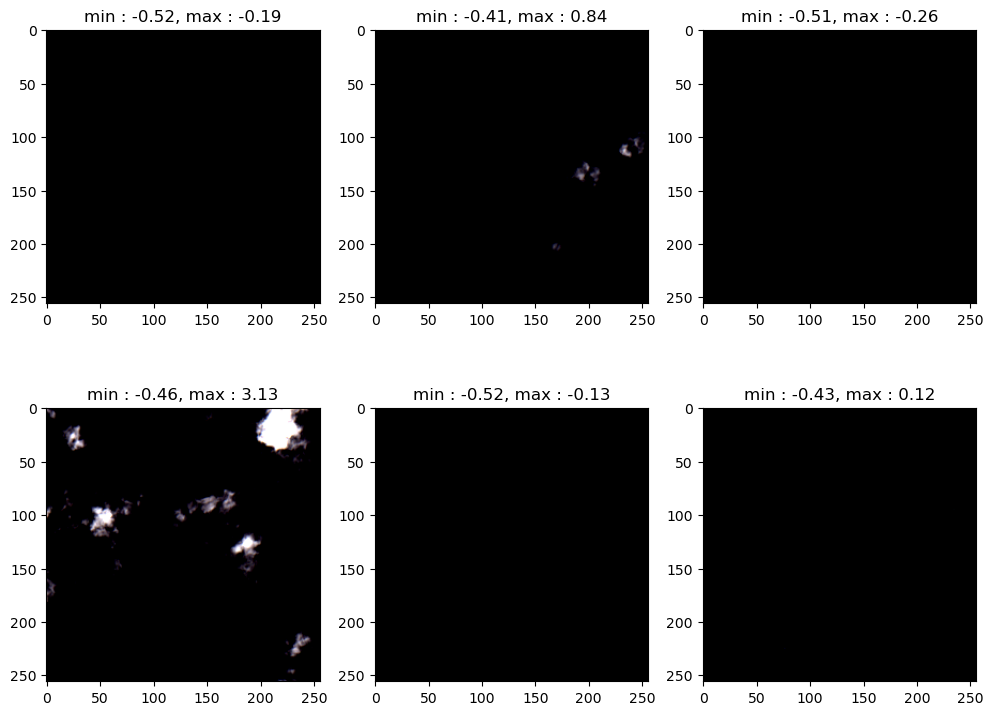

In [74]:
#batch, paths = next(iter(sentinel_loader))
plot_image_from_batch(batch)


In [13]:
rand_idxs.reshape(-1,1)

array([[197],
       [424],
       [185],
       [ 26],
       [251],
       [483]])

In [14]:
batch.shape

torch.Size([512, 3, 256, 256])

In [2]:
sf = 2
if sf:
    print("exec")

exec


In [4]:
import torch
type(torch.tensor([1,2]))

torch.Tensor